# Mapping the Networks

Mapping the networks with the location of the nodes as their latitude and longitude locations.

In [16]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from mpl_toolkits.basemap import Basemap as Basemap
from shapely.geometry import Point

In [14]:
# prep the fishing areas
# add in the data for fishing vessel areas
areas = gpd.read_file('../data/fishing_areas_geo.csv')

# get lat and long from points
areas['fishing_area_long'] = areas['geometry'].x
areas['fishing_area_lat'] = areas['geometry'].x


AttributeError: 'Series' object has no attribute 'x'

In [81]:
# read in the csv with the fishing vessel info
fvs = pd.read_csv("../data/geo_ais_rfv_all.csv")

# add in the data for fishing vessel areas
areas = pd.read_csv('../data/fishing_areas_geo.csv')

# combine datasets
all_data = pd.merge(fvs, areas,left_on = 'fishing_area', right_on='short_name')
all_data.dropna()

print(all_data.head())

  flag     vessel_name  fishing_hours   fishing_area  \
0  CHN    DONG YU 1521          22.86           hsp7   
1  CHN    DONG YU 1521         291.10           hsp6   
2  CHN    DONG YU 1521        1421.71   kirbati2_eez   
3  CHN    DONG YU 1521         741.84  kiribati1_eez   
4  CHN  FENG XIANG 818          12.19      nauru_eez   

                                     owner   vessel_type  \
0  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner   
1  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner   
2  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner   
3  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner   
4    Ningbo Yongfa Ocean Fisheries CO.,LTD  Purse seiner   

                                       owner_address owner_providence_state  \
0  Room 503, 5F, Building 1, No. 1 Xingye Road, G...               Zhejiang   
1  Room 503, 5F, Building 1, No. 1 Xingye Road, G...               Zhejiang   
2  Room 503, 5F, Building 1, No. 1 Xingye Road, G...             

In [82]:
G = nx.from_pandas_edgelist(all_data, source = 'home_port_name', target = 'GEONAME',
                        edge_attr = 'fishing_hours')

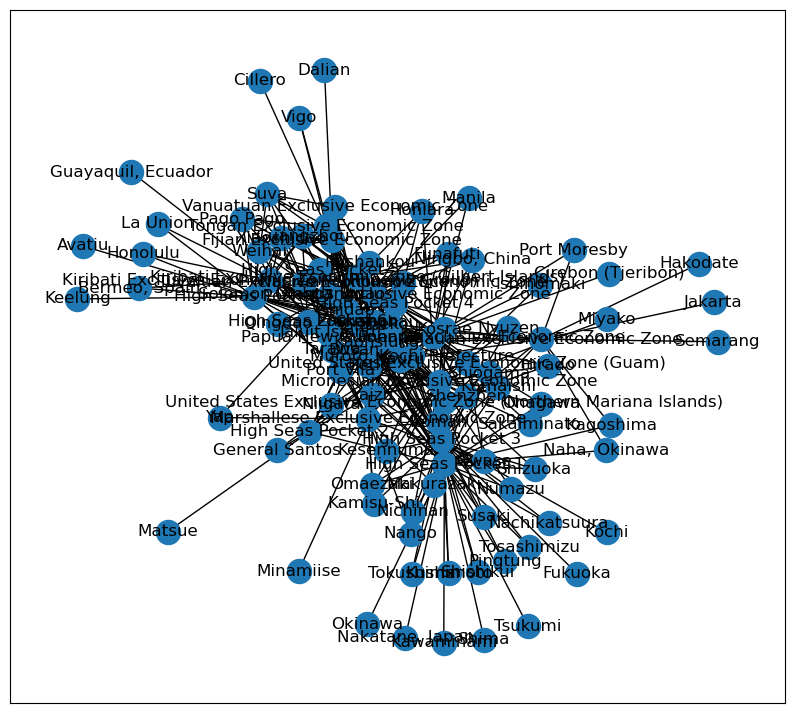

In [83]:
plt.figure(figsize = (10,9))
nx.draw_networkx(G)
plt.show()

In [ ]:
# Preprocess locations data

# Convert western hemisphere longitudes for Pacific-centered view
# This must be done because the map is flipped contrary to most projectsion
def adjust_longitude_for_pacific(lon):
    """Convert longitude to Pacific-centered view (0-360° system)"""
    return lon if lon >= 0 else lon + 360

# Get unique nodes for each type
home_ports = all_data[['home_port_name', 'home_port_longitude', 'home_port_latitude']].drop_duplicates()
fishing_areas = all_data[['GEONAME', 'fishing_area_long', 'fishing_area_lat']].drop_duplicates()

# Apply to your data before transformation
home_ports_adj = home_ports.copy()
fishing_areas_adj = fishing_areas.copy()

home_ports_adj['home_port_longitude'] = home_ports_adj['home_port_longitude'].apply(adjust_longitude_for_pacific)
fishing_areas_adj['fishing_area_long'] = fishing_areas_adj['fishing_area_long'].apply(adjust_longitude_for_pacific)


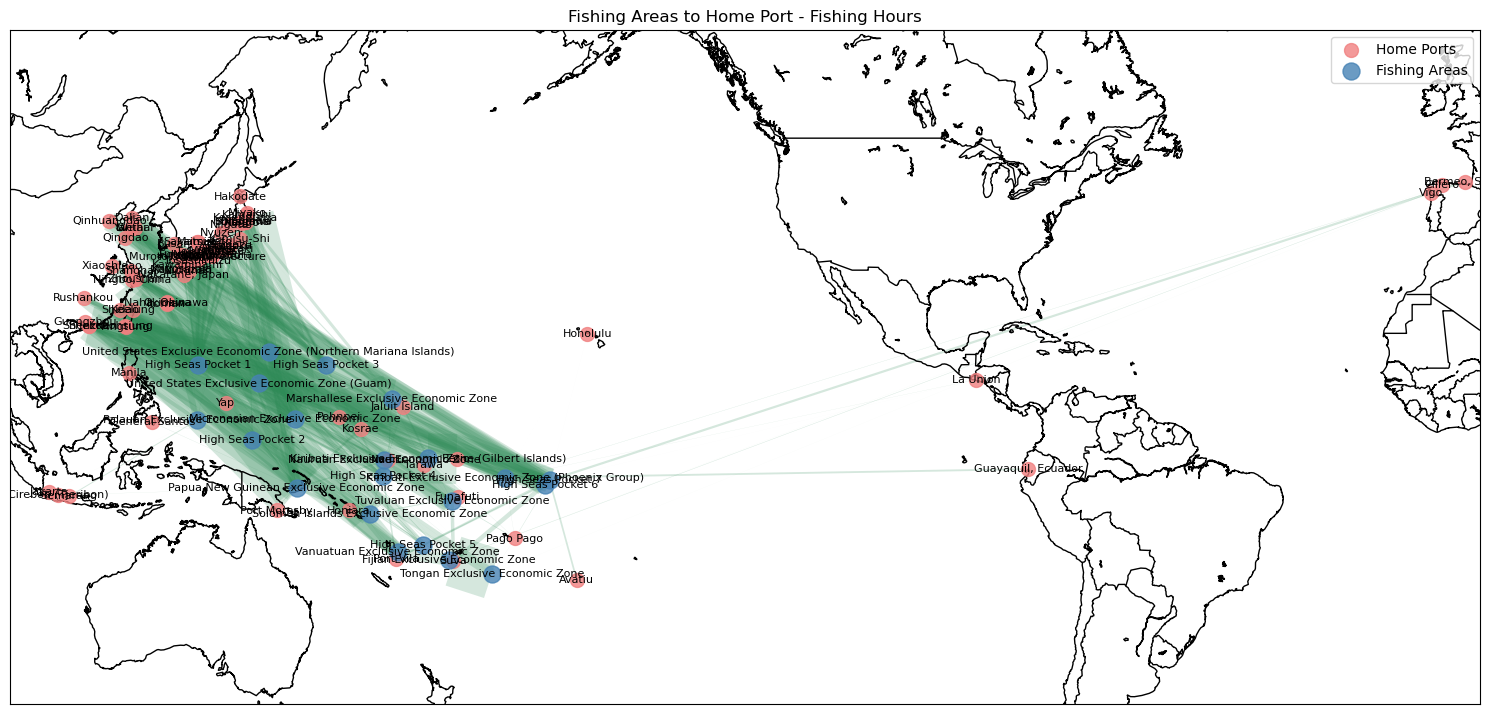

In [96]:
# create map size
plt.figure(figsize=(15,9))

# import base map with proper demarcations
m = Basemap(
    projection='merc',
    llcrnrlon=100,
    llcrnrlat=-40,
    urcrnrlon=360,
    urcrnrlat=60,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True)

# draw the map boundaries
m.drawcountries(linewidth = 1)
m.drawcoastlines(linewidth=1)

## Now add in the graph data

# Adjust coordinates to the same CRS as the basemap
mx_ports, my_ports = m(home_ports_adj['home_port_longitude'].values, home_ports_adj['home_port_latitude'].values)
mx_areas, my_areas = m(fishing_areas_adj['fishing_area_long'].values, fishing_areas_adj['fishing_area_lat'].values)

# Create separate position dictionaries for the two types of nodes
pos_ports = {port: (mx_ports[i], my_ports[i]) for i, port in enumerate(home_ports['home_port_name'])}
pos_areas = {area: (mx_areas[i], my_areas[i]) for i, area in enumerate(fishing_areas['GEONAME'])}

# Draw the nodes
nx.draw_networkx_nodes(G, pos_ports, nodelist=list(pos_ports.keys()), 
                      node_color='lightcoral', alpha = 0.8, node_size=100, label='Home Ports')
nx.draw_networkx_nodes(G, pos_areas, nodelist=list(pos_areas.keys()), 
                      node_color='steelblue', alpha = 0.8, node_size=150, label='Fishing Areas')

# Combine positions
pos_combined = {**pos_ports, **pos_areas}
# Get edge weights and create a list of widths
edge_weights = nx.get_edge_attributes(G, 'fishing_hours')
widths = [edge_weights[edge]/100 for edge in G.edges()]
# draw the edges
nx.draw_networkx_edges(G, pos = pos_combined, width=widths, edge_color='seagreen', alpha=0.2, arrows = False)

nx.draw_networkx_labels(G, pos_combined, font_size=8)
plt.legend()
plt.title("Fishing Areas to Home Port - Fishing Hours")
plt.tight_layout()
plt.show()

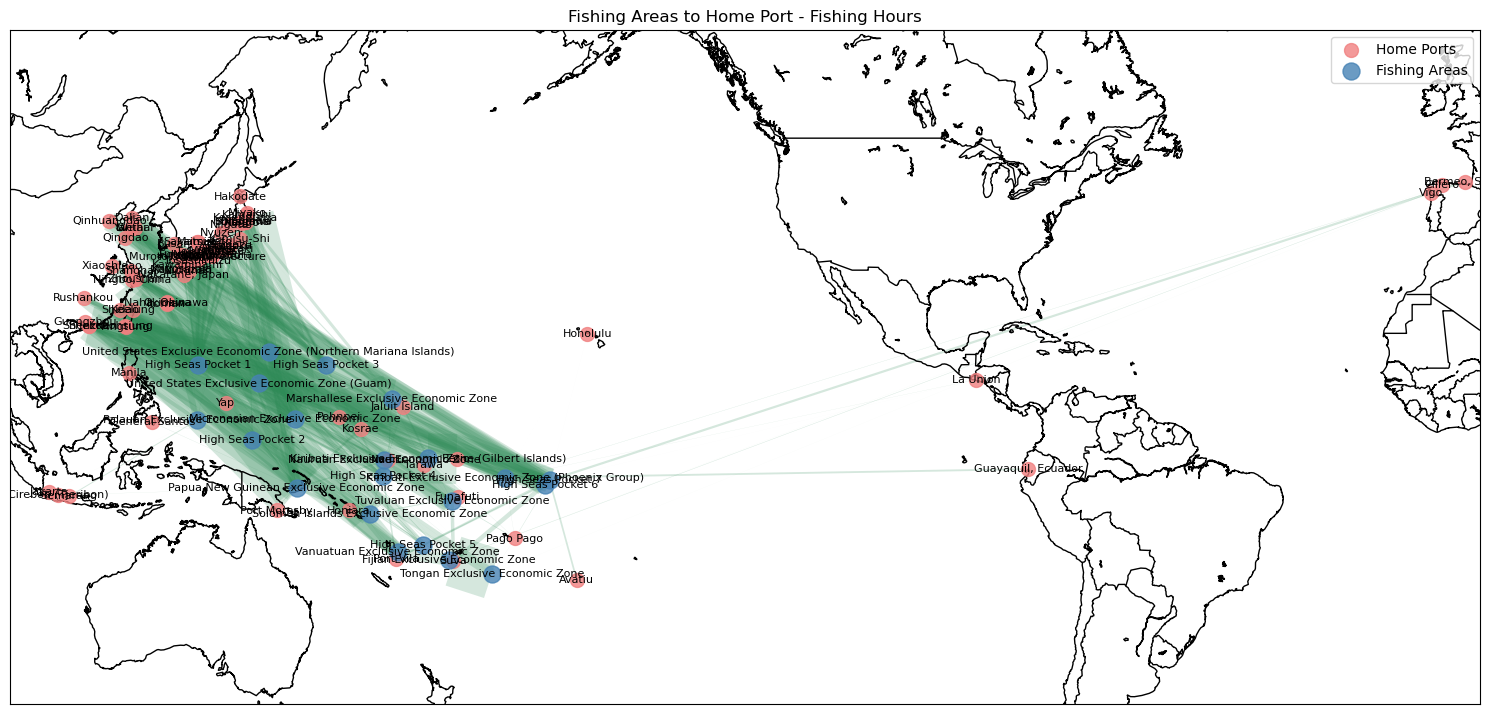

In [113]:
plt.figure(figsize=(15,9))
m = Basemap(
    projection='merc',
    llcrnrlon=100,
    llcrnrlat=-40,
    urcrnrlon=360,
    urcrnrlat=60,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True)

m.drawcountries(linewidth = 1)
m.drawcoastlines(linewidth=1)


# Draw nodes
# Draw the nodes
nx.draw_networkx_nodes(G, pos_ports, nodelist=list(pos_ports.keys()), 
                      node_color='lightcoral', alpha = 0.8, node_size=100, label='Home Ports')
nx.draw_networkx_nodes(G, pos_areas, nodelist=list(pos_areas.keys()), 
                      node_color='steelblue', alpha = 0.8, node_size=150, label='Fishing Areas')

# draw the edges
nx.draw_networkx_edges(G, pos = pos_combined, width=widths, edge_color='seagreen', alpha=0.2, arrows = False)

nx.draw_networkx_labels(G, pos_combined, font_size=8)
plt.legend()
plt.title("Fishing Areas to Home Port - Fishing Hours")
plt.tight_layout()
plt.show()